In [1]:
# Calculating bus factor for FOSS projects
# https://chaoss.community/metric-bus-factor/
# Ingests csv that were generated with
# echo '"hash","authName","authEmail","authDate","commName","commEmail","commDate","Subject"'
# git log --date=local --pretty=format:'%h,"%aN","%aE",%as,"%cN","%cE",%cs,"%f"'

In [2]:
import pandas as pd
from datetime import date


In [3]:
REPO_GIT_LOG_CSV = "local_csv/ffmpeg_commits.csv"
AUTHORS_IN_GRAPH = 7
BUS_THRESHOLD = 0.5

In [4]:
df = pd.read_csv(REPO_GIT_LOG_CSV, parse_dates=['authDate','commDate'])

In [5]:
# df.info()

In [6]:
# Get the year range
year_start = df['commDate'].min().year
# year_start = 2016
# year_end = df['commDate'].max().year
year_end = date.today().year

In [7]:
# Get the top AUTHORS_IN_GRAPH contributors

top_contributors = df[(df['commDate'].dt.year >= year_start) & (df['commDate'].dt.year <= year_end)]['authName'].value_counts(normalize=True).nlargest(n=AUTHORS_IN_GRAPH)
# top_contributors = df['authName'].value_counts(normalize=True).nlargest(n=AUTHORS_IN_GRAPH)
# df[(df['commDate'].dt.year >= year_start) & (df['commDate'].dt.year <= year_end)]
for contributor in top_contributors.index:
    print(contributor)
list_contributors = list(top_contributors.index)

Michael Niedermayer
Andreas Rheinhardt
Paul B Mahol
James Almer
Clément Bœsch
Anton Khirnov
Mark Thompson


In [8]:
print(year_start,year_end-1)

2016 2021


In [9]:
years = list(range(year_start,year_end)) # We don't want the current year as it will give deceiving results for absolute values
columns = list_contributors+["Others"]
ydf = pd.DataFrame(
    columns=list_contributors,
    index=years)
ydf_abs = pd.DataFrame(
    columns=list_contributors,
    index=years)
df_bus = pd.DataFrame(
    columns=["Bus Factor"],
    index=years)

for year in years:
    yearly_authors = df[df['commDate'].dt.year == year]['authName'].value_counts(normalize=True)
    yearly_authors_abs = df[df['commDate'].dt.year == year]['authName'].value_counts(normalize=False)
    # print("=== Year ===", year)
    # print(yearly_authors)
    total_known = 0
    total_known_abs = 0   
    for author in list_contributors:
        if author in yearly_authors:
            ydf.loc[year,author] = yearly_authors[author]
            ydf_abs.loc[year,author] = yearly_authors_abs[author]
            total_known += yearly_authors[author]
            total_known_abs += yearly_authors_abs[author]
        else:
            ydf.loc[year,author] = 0
            ydf_abs.loc[year,author] = 0
    ydf.loc[year,"Others"] = 1-total_known
    ydf_abs.loc[year,"Others"] = (df[df['commDate'].dt.year == year]['authName'].count())-total_known_abs
    # Actually calculating the bus factor
    bus_factor = 0
    total = 0
    if len(yearly_authors>0):
        while total< BUS_THRESHOLD:
            total += yearly_authors[bus_factor]
            bus_factor +=1
    # print("bus_factor",bus_factor)
    df_bus.loc[year,"Bus Factor"] = bus_factor
    
# print(ydf)


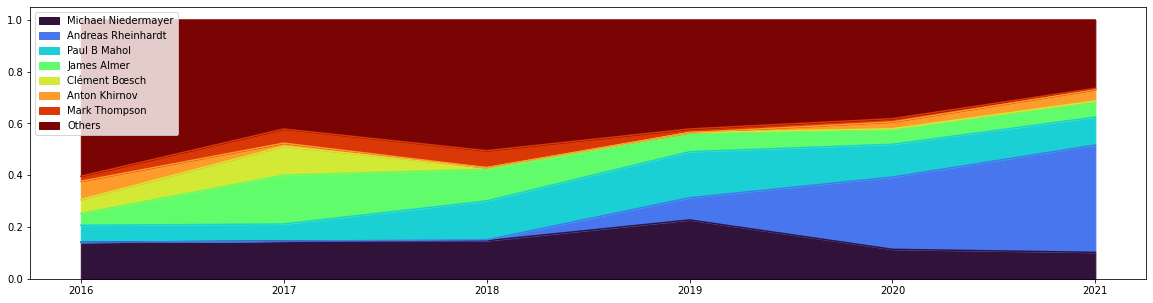

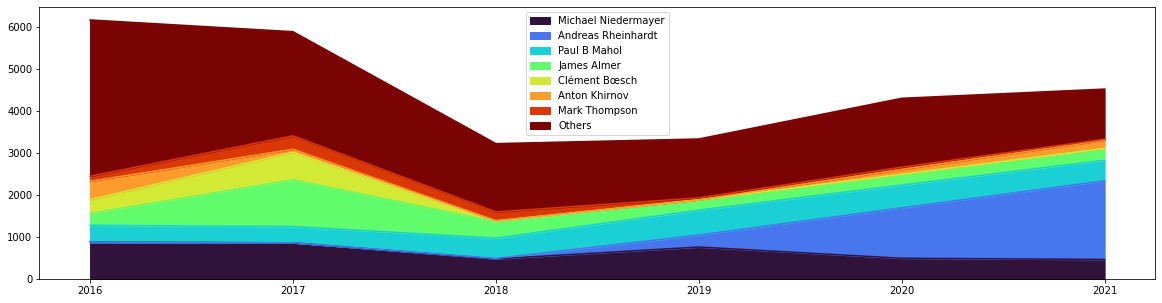

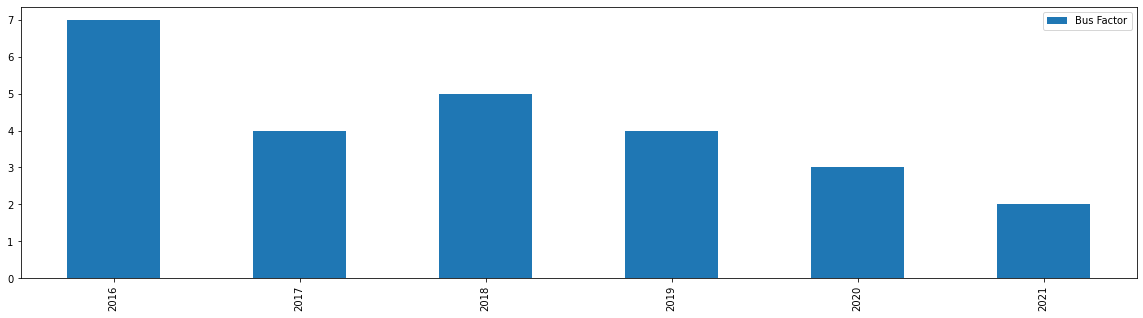

In [10]:
# Plotting the graphs
# Colormaps: https://matplotlib.org/stable/gallery/color/colormap_reference.html
fig = ydf.plot.area(colormap="turbo", figsize=(20,5)).get_figure()
fig_abs = ydf_abs.plot.area(colormap="turbo", figsize=(20,5)).get_figure()
fig_bus = df_bus.plot.bar(figsize=(20,5)).get_figure()

In [11]:
# Saving the data to CSV
ydf.to_csv(REPO_GIT_LOG_CSV[:-4]+"_contrib_rel.csv")
ydf_abs.to_csv(REPO_GIT_LOG_CSV[:-4]+"_contrib_abs.csv")
df_bus.to_csv(REPO_GIT_LOG_CSV[:-4]+"_bus_factor.csv")


In [12]:
# Saving figures as pngs
fig.savefig(REPO_GIT_LOG_CSV[:-4]+"_contrib_rel.png")
fig_abs.savefig(REPO_GIT_LOG_CSV[:-4]+"_contrib_abs.png")
fig_bus.savefig(REPO_GIT_LOG_CSV[:-4]+"_contrib_bus.png")